In [1]:
!pip install numpy
!pip install pandas
!pip install scipy
!pip install ipywidgets

#%matplotlib inline # from the example in the documentation. but doesn't seem necessary in current JupyterLab 3.1.11 or the classic notebook available now https://github.com/fomightez/communication_voila
import sys
print('python executable is',sys.executable)
import numpy as np
import scipy as sp
import scipy.fftpack as fftpack
import math
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

DEFAULT_GREY = ('0.8')
DEFAULT_BLUE = '#1f77b4'
DEFAULT_RED = '#d62728'

PI = math.pi


DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.

python executable is /usr/local/opt/python@3.9/bin/python3.9


/var/folders/vq/6kh7t9sn3r9clvrnhcp7vwcr0000gn/T/ipykernel_73260/2543016148.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


# Overview

This notebook is a general introduction to what an NMR FID looks like, what happens you ntruncate them and a add bad data and processing NMR data using window functions

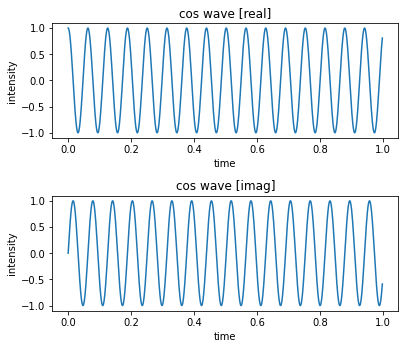

In [2]:
#%% sine wave
frequency=100.0
data_size=1024


def plot_complex (xs,ys,title='', xl='', yl='',save_name = "unknown.svg"):
    fig=plt.figure()

    ax1=fig.add_axes([0.1, 1.0, 0.8, 0.4])
    ax1.plot(xs,np.real(ys))
    ax1.set_title('%s [real]' % title)
    ax1.set_xlabel(xl)
    ax1.set_ylabel(yl)

   
    ax2=fig.add_axes([0.1, 0.40, 0.8, 0.4])
    ax2.plot(xs,np.imag(ys))
    ax2.set_title('%s [imag]' % title)
    ax2.set_ylabel(yl)
    ax2.set_xlabel(xl)
    
#     fig.savefig(save_name, bbox_inches='tight')

    plt.show()


def sin_wave(frequency, data_size=1024):
    xs=[i/data_size for i in np.arange(data_size)]
    ys = [i * frequency for i in xs]
    ysc=np.cos(ys) + 1j * np.sin(ys) 
    
    return xs,ysc
    

@interact(frequency=(0.0,data_size/2.0))
def plot_sin_wave(frequency=frequency):
    xs, ysc = sin_wave(frequency)
    plot_complex(xs,ysc,'cos wave', 'time', 'intensity', save_name = "cos-sin.svg")




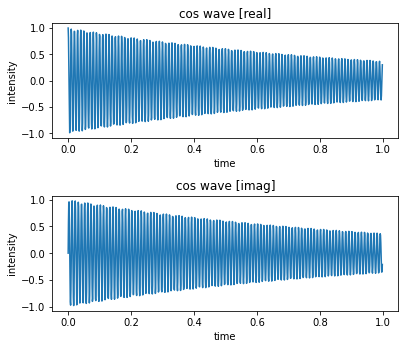

In [3]:
# #%% damped sine wave

relaxation = 1

def exp_win(xs,ys, lb):
    as_  = [np.exp(-lb*x) for x in xs]

    return xs,  ys * as_

def damped_sin_wave(frequency, relaxation, data_size=1024):
    xs, ysc = sin_wave(frequency * 2.0 * math.pi, data_size=data_size)
    xs,ysc = exp_win(xs,ysc, relaxation)
    
    return xs,ysc

@interact(frequency=(0.0,data_size/2.0), relaxation = (0.0,20.0))
def plot_damped_sin_wave(frequency=frequency, relaxation=relaxation):
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    plot_complex(xs,ysc,'cos wave', 'time', 'intensity', save_name='damped_cos_sin.svg')



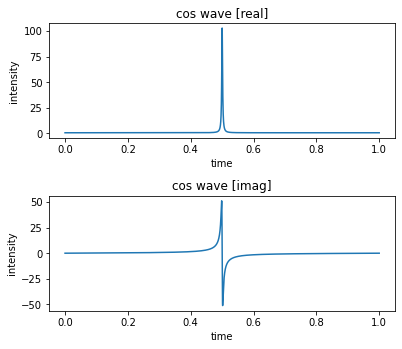

In [4]:
# #%% fft

def zero_fill(xs,ysc, extra=None):
    

    if extra == None:
        len_ysc = len(ysc)
        extra = len_ysc//2

    ysc=np.pad(ysc,extra//2)
    ysc=np.roll(ysc,-extra//2)

    
    increment = (xs[1]-xs[0])/2

    
    new_xs = np.arange(0.0,1.0,1.0/len(ysc))
    return new_xs, ysc
      

@interact(frequency=(50,data_size-50),value=data_size//2)
def plot_fft_damped_sin_wave(frequency):
    relaxation=10
    xs,ysc = damped_sin_wave(frequency,relaxation)
    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)

    
    yscft = fftpack.fft(ysc)
    plot_complex(xs,yscft,'cos wave', 'time', 'intensity')



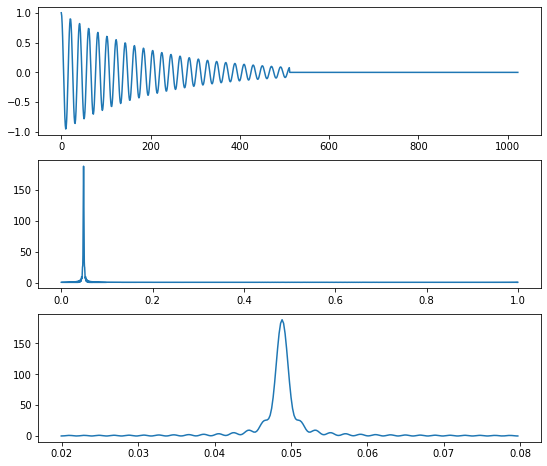

In [5]:


def plot_real_dat_detail_complex (xs,rys, ys,title='', xl='', yl='', detail=(0.0,1.0),save_name='Untitled.svg'):
    fig=plt.figure(figsize=(9, 8))

    ax0,ax1,ax2=fig.subplots(3)
    
    rxs = range(len(rys))
    ax0.plot(rxs,rys)

    ax1.plot(xs,np.real(ys))


   
    start = int(len(xs) * detail[0])
    end = int(len(xs) * detail[1])
    ax2.plot(xs[start:end],np.real(ys)[start:end])

    fig.savefig(save_name, bbox_inches='tight')
    
    plt.show()

    
def step(xs,ys,percentage=0.5):
    
    len_ys = len(ys)
    len_1s = int(len_ys *percentage)
    step = np.zeros(len_ys)
    for i in range(int(len(ys)*percentage)):
        step[i] = 1.0
        
    return xs, ys * step
        
    
@interact(percent=(0.0,1.0))
def plot_fft_damped_sin_wave(percent=0.5):
    frequency = 50
    
    relaxation=5
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    rysc = np.real(ysc)
    
    xs,ysc = step(xs,ysc,percent)
    rysc = np.real(ysc)
    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)
    yscft = fftpack.fft(ysc)

    plot_real_dat_detail_complex(xs,rysc, yscft,'cos wave', 'time', 'intensity',detail=(0.02,0.08))
    

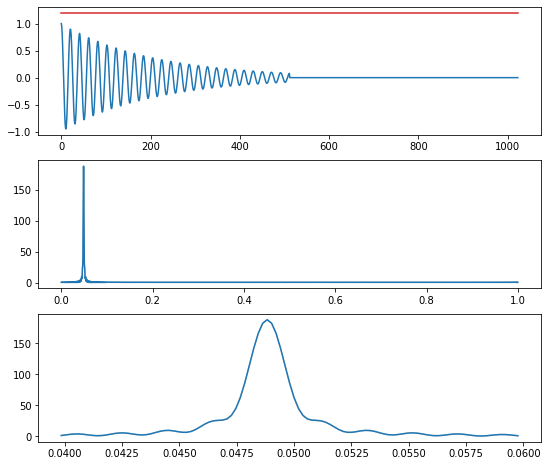

In [6]:

lb =1

def offset(xs,ys,offset=0.0):
    return xs,ys + offset

def plot_real_data_detail_complex_overlay (xs,rys, ys,title='', xl='', yl='', detail=(0.0,1.0), colors = None, save_name='Untitled.svg'):
    fig=plt.figure(figsize=(9, 8))

    if colors == None:
        colors  = ((DEFAULT_RED, DEFAULT_BLUE),(DEFAULT_GREY,DEFAULT_BLUE),(DEFAULT_GREY,DEFAULT_BLUE))
    ax0,ax1,ax2=fig.subplots(3)
    
    overlay = None
    if not isinstance(rys[0],float):
        real_rys=rys[0]
        overlay = rys[1]

    
    overlay_ys = None
    if not isinstance(ys[0],(float,complex)):

        real_ys=ys[0]
        overlay_ys = ys[1]

        
        
        
    rxs = range(len(real_rys))
    if overlay is None:
        ax0.plot(rxs,real_rys, colors[0][1])
    else:
        ax0.plot(rxs,real_rys, colors[0][0], rxs,overlay, colors[0][1])

    if overlay_ys is None:
        ax1.plot(xs,np.real(ys),colors[1][1])
    else:
        ax1.plot(xs,np.real(real_ys), colors[1][0], xs, np.real(overlay_ys), colors[1][1])


   
    start = int(len(xs) * detail[0])
    end = int(len(xs) * detail[1])
    if overlay_ys is None:
        ax2.plot(xs[start:end],np.real(ys)[start:end], colors[2][1])
    else:
        xsd = xs[start:end]
        ysd = np.real(real_ys)[start:end]

        
        ax2.plot(xs[start:end],np.real(real_ys)[start:end],colors[2][0],xs[start:end],np.real(overlay_ys)[start:end], colors[2][1])
    
    fig.savefig(save_name, bbox_inches='tight')
    
    plt.show()


    
@interact(lb=(0,20),percent=(0.0,1.0), trunk_over=True, left_limit=(0.0,1.0, 0.01), right_limit=(0.0, 1.0, 0.01))
def plot_exp_multiplied_sin_wave(lb=0,percent=0.5,trunk_over=True, left_limit=0.04, right_limit=0.06):
    
    if right_limit < left_limit:
        right_limit = left_limit+0.1
    
    if left_limit > right_limit:
        left_limit =  right_limit - 0.1
        
    if left_limit < 0.0:
        left_limit = 0.0
    
    if right_limit > 1.0:
        right_limit =1.0
        
    frequency = 50
    
    relaxation=5
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    rysc = np.real(ysc)
    ysc0 = np.array(ysc,copy=True)
    
    if trunk_over:
        xs, ysc0 = step(xs,ysc0,percent)

    
    xs,ysc = step(xs,ysc,percent)
    xs,ysc = exp_win(xs,ysc,lb)
    rysc = np.real(ysc)
    
    
    
    exp_cur = np.ones(len(ysc))
   
    xs, exp_cur = exp_win(xs,exp_cur,lb)
    xs, exp_cur = offset(xs,exp_cur,0.2)
        

    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)
    yscft = fftpack.fft(ysc)

    xs,ysc0 =  zero_fill(xs,ysc0,len(ysc0)*4)
    ysc0ft = fftpack.fft(ysc0)

    

    plot_real_data_detail_complex_overlay(xs,[exp_cur, rysc], [ysc0ft,yscft],'cos wave', 'time', 'intensity',detail=(left_limit,right_limit))

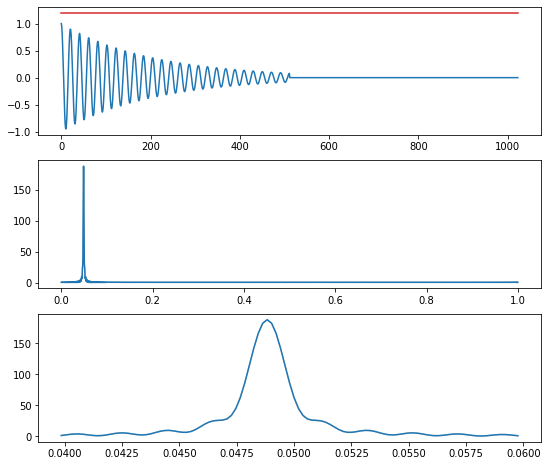

In [7]:

def gm_win(xs,ys,lb, gb, sw=10000):
    
    aq = 1/sw * len(ys)
    PI = math.pi
    
    window = []
    for i, y in enumerate(ys):
        t = xs[i] * aq 
        fact_1 = -PI * t * lb
        fact_2 = (-PI * lb * t**2) / (2 * gb * aq)
        window.append( math.exp(fact_1 - fact_2))
    
    return xs,ys * window

@interact(lb=(-40,20, 0.1),gm=(0.0001,1),percent=(0.0,1.0), trunk_over=True, left_limit=(0.0,1.0, 0.01), right_limit=(0.0, 1.0, 0.01))
def plot_gm_multiplied_sin_wave(lb=0,gm=0.1,percent=0.5,trunk_over=True, left_limit=0.04, right_limit=0.06):
    
    if right_limit < left_limit:
        right_limit = left_limit+0.1
    
    if left_limit > right_limit:
        left_limit =  right_limit - 0.1
        
    if left_limit < 0.0:
        left_limit = 0.0
    
    if right_limit > 1.0:
        right_limit =1.0
        
    frequency = 50
    
    relaxation=5
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    rysc = np.real(ysc)
    ysc0 = np.array(ysc,copy=True)
    
    if trunk_over:
        xs, ysc0 = step(xs,ysc0,percent)

    
    xs,ysc = step(xs,ysc,percent)
    xs,ysc = gm_win(xs,ysc,lb, gm)
    rysc = np.real(ysc)
    
    
    
    exp_cur = np.ones(len(ysc))
   
    xs, exp_cur = gm_win(xs,exp_cur,lb, gm)
    xs, exp_cur = offset(xs,exp_cur,0.2)
        

    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)
    yscft = fftpack.fft(ysc)

    xs,ysc0 =  zero_fill(xs,ysc0,len(ysc0)*4)
    ysc0ft = fftpack.fft(ysc0)

    

    plot_real_data_detail_complex_overlay(xs,[exp_cur, rysc], [ysc0ft,yscft],'cos wave', 'time', 'intensity',detail=(left_limit,right_limit))

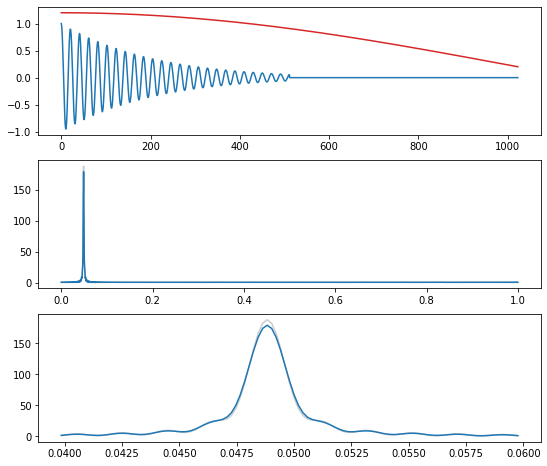

In [8]:
def sin_win(xs,ys, start=-1.0, end=1.0, power=1, trunc=0.5): #start=0,end=1
    
    
    
    num_points = len(ys)

    active_points =  int(num_points * end)
    
    func_points = active_points +  active_points * -start
    

    func_length = end-start
        
    func_increment = PI / func_points
    func_start = func_increment * (func_points- active_points)
    

    
    window = np.zeros( num_points)
    increment = PI/active_points
    for i in range(active_points):
        window[i] = math.sin(func_start + (i*func_increment))**power
    
    
#     window = np.zeros(num_points)    
#     for i in range(num_points):
#         fact_1 = PI/off
#         fact_2 = (PI*(end-off)/(size-1))
#         value = math.sin(fact_1  + (fact_2*i) )**power
# #         print(value)
#         window[i] = value
    
#     windowed_points = int((num_points - 1) * proportion) 
#     for i in range(windowed_points+1):
#         pos = i / windowed_points
#         print(pos-1)
        
#         window[i] = (math.sin(pos-offset))
    
    return xs,ys * window

@interact(trunk_over=True, start=(-1.0,0.0,0.01) , end=(0.01, 1.0, 0.01), power=(1,10,1),left_limit=(0.0,1.0, 0.01), right_limit=(0.0, 1.0, 0.01))
def plot_sin_multiplied_sin_wave(percent=0.5,trunk_over=True, start=-1.0, end=1.0, power=1.0, left_limit=0.04, right_limit=0.06):
    
    if right_limit < left_limit:
        right_limit = left_limit+0.1
    
    if left_limit > right_limit:
        left_limit =  right_limit - 0.1
        
    if left_limit < 0.0:
        left_limit = 0.0
    
    if right_limit > 1.0:
        right_limit =1.0
        
    frequency = 50
    
    relaxation=5
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    rysc = np.real(ysc)
    ysc0 = np.array(ysc,copy=True)
    
    if trunk_over:
        xs, ysc0 = step(xs,ysc0,percent)

    
    xs,ysc = step(xs,ysc,percent)
    xs,ysc = sin_win(xs,ysc, start=start, end=end, power=power)
    rysc = np.real(ysc)
    
    
    
    exp_cur = np.ones(len(ysc))
   
    xs, exp_cur = sin_win(xs,exp_cur, start=start, end=end,  power=power)
    xs, exp_cur = offset(xs,exp_cur,0.2)
        

    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)
    yscft = fftpack.fft(ysc)

    xs,ysc0 =  zero_fill(xs,ysc0,len(ysc0)*4)
    ysc0ft = fftpack.fft(ysc0)

    

    plot_real_data_detail_complex_overlay(xs,[exp_cur, rysc], [ysc0ft,yscft],'cos wave', 'time', 'intensity',detail=(left_limit,right_limit))

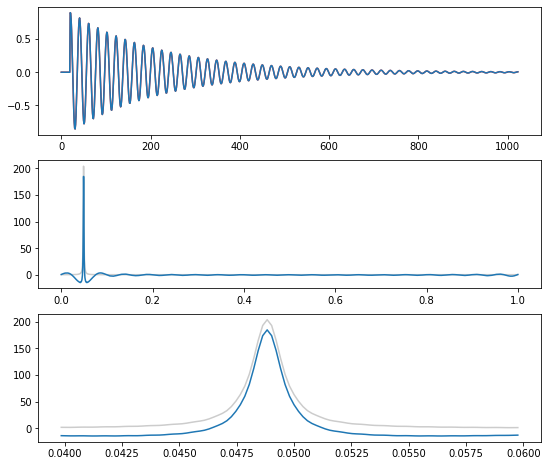

In [9]:
@interact(trunk_over=True, bad_value=(-10,10,0.10), bad_value_length=(0,100), bad_value_offset=(0,1024,1),left_limit=(0.0,1.0, 0.01), right_limit=(0.0, 1.0, 0.01))
def plot_bad_first_points_sin_wave(trunk_over=True, bad_value=0.0, bad_value_length=20, bad_value_offset=0,left_limit=0.04, right_limit=0.06):
    
    if right_limit < left_limit:
        right_limit = left_limit+0.1
    
    if left_limit > right_limit:
        left_limit =  right_limit - 0.1
        
    if left_limit < 0.0:
        left_limit = 0.0
    
    if right_limit > 1.0:
        right_limit =1.0
        
    frequency = 50
    
    relaxation=5
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    ysc0 = np.array(ysc,copy=True)
    
    rysc = np.real(ysc)
    
    for i in range(bad_value_offset,bad_value_offset + bad_value_length):
        if i < len(ysc):
            ysc[i] = bad_value

    
    
    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)
    yscft = fftpack.fft(ysc)

    xs,ysc0 =  zero_fill(xs,ysc0,len(ysc0)*4)
    ysc0ft = fftpack.fft(ysc0)

    

    plot_real_data_detail_complex_overlay(xs,[rysc, rysc], [ysc0ft,yscft],'cos wave', 'time', 'intensity',detail=(left_limit,right_limit))

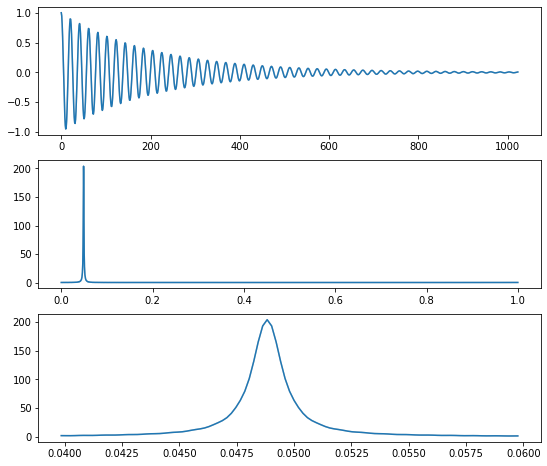

In [10]:
@interact(trunk_over=True, clip=(0.0,1.0,0.01),left_limit=(0.0,1.0, 0.01), right_limit=(0.0, 1.0, 0.01))
def plot_bad_clip_sin_wave(trunk_over=True, clip=1.0, bad_value_offset=0,left_limit=0.04, right_limit=0.06):
    
    if right_limit < left_limit:
        right_limit = left_limit+0.1
    
    if left_limit > right_limit:
        left_limit =  right_limit - 0.1
        
    if left_limit < 0.0:
        left_limit = 0.0
    
    if right_limit > 1.0:
        right_limit =1.0
        
    frequency = 50
    
    relaxation=5
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    ysc0 = np.array(ysc,copy=True)
    
    
    rysc0  = np.real(ysc)

    ysc = np.clip(ysc,-clip,clip)
    
    rysc = np.real(ysc)
    
    
    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)
    yscft = fftpack.fft(ysc)

    xs,ysc0 =  zero_fill(xs,ysc0,len(ysc0)*4)
    ysc0ft = fftpack.fft(ysc0)

    
    colors=((DEFAULT_GREY,DEFAULT_BLUE),(DEFAULT_GREY,DEFAULT_BLUE),(DEFAULT_GREY,DEFAULT_BLUE))

    plot_real_data_detail_complex_overlay(xs,[rysc0, rysc], [ysc0ft,yscft],'cos wave', 'time', 'intensity',detail=(left_limit,right_limit),colors=colors)

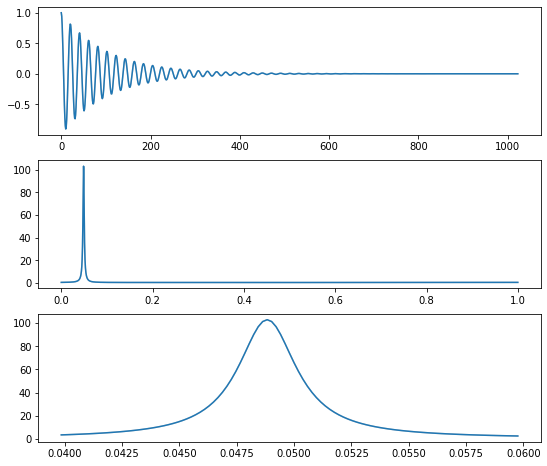

In [11]:
@interact(trunk_over=True, offset=(0,50),left_limit=(0.0,1.0, 0.01), right_limit=(0.0, 1.0, 0.01))
def plot_offset_data_sin_wave(trunk_over=True, offset=0,left_limit=0.04, right_limit=0.06):
    
    if right_limit < left_limit:
        right_limit = left_limit+0.1
    
    if left_limit > right_limit:
        left_limit =  right_limit - 0.1
        
    if left_limit < 0.0:
        left_limit = 0.0
    
    if right_limit > 1.0:
        right_limit =1.0
        
    frequency = 50
    
    relaxation=10
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    ysc0 = np.array(ysc,copy=True)
    
    
    rysc0  = np.real(ysc)
    
    ysc = np.roll(ysc,offset)
        
    rysc = np.real(ysc)
    
    
    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)
    yscft = fftpack.fft(ysc)

    xs,ysc0 =  zero_fill(xs,ysc0,len(ysc0)*4)
    ysc0ft = fftpack.fft(ysc0)

    
    colors=((DEFAULT_GREY,DEFAULT_BLUE),(DEFAULT_GREY,DEFAULT_BLUE),(DEFAULT_GREY,DEFAULT_BLUE))

    plot_real_data_detail_complex_overlay(xs,[rysc0, rysc], [ysc0ft,yscft],'cos wave', 'time', 'intensity',detail=(left_limit,right_limit),colors=colors)

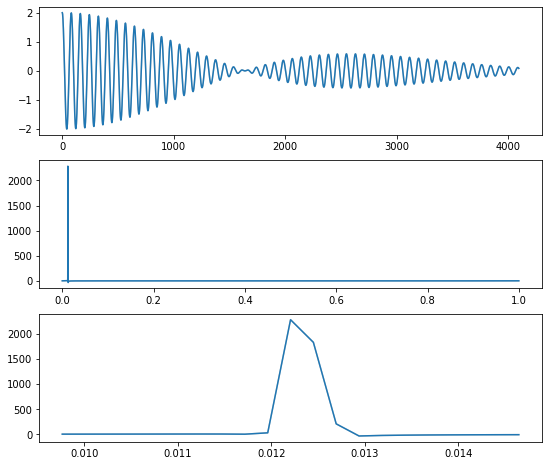

In [12]:
@interact(trunk_over=True, zero_fills=(0,8,1), relaxation=(0,5,0.1), frequency=(49.5,50.5,0.1), frequency_offset=(0.0,2.0,0.05))
def plot_offset_data_sin_wave(trunk_over=True, zero_fills=0,left_limit=0.01, right_limit=0.015, relaxation=0.2, frequency=50, frequency_offset=1.25):
    
    if right_limit < left_limit:
        right_limit = left_limit+0.1
    
    if left_limit > right_limit:
        left_limit =  right_limit - 0.1
        
    if left_limit < 0.0:
        left_limit = 0.0
    
    if right_limit > 1.0:
        right_limit =1.0
        
#     frequency = 50
#     frequency_offset=1.25
    frequency_2 = frequency+frequency_offset
    

    
    xs,ysc = damped_sin_wave(frequency,relaxation, data_size=1024*4)
    xs,ysc_2 = damped_sin_wave(frequency_2,relaxation,data_size=1024*4)
    

    ysc= ysc + ysc_2
    
    xs, ysc = gm_win(xs,ysc,-0.20, 0.05)
        
    
    ysc0 = np.array(ysc,copy=True)
    
    
    

    
    zero_fill_length = (len(ysc)*(2**zero_fills))-len(ysc)
    

    xs,ysc =  zero_fill(xs,ysc,zero_fill_length)

    
    rysc0  = np.real(ysc)
    

        
    rysc = np.real(ysc)
    
    yscft = fftpack.fft(ysc)
    

    xs,ysc0 =  zero_fill(xs,ysc0,zero_fill_length)
    ysc0ft = fftpack.fft(ysc0)

    
    colors=((DEFAULT_GREY,DEFAULT_BLUE),(DEFAULT_GREY,DEFAULT_BLUE),(DEFAULT_GREY,DEFAULT_BLUE))

    plot_real_data_detail_complex_overlay(xs,[rysc0, rysc], [ysc0ft,yscft],'cos wave', 'time', 'intensity',detail=(left_limit,right_limit),colors=colors)

## Ideas

1. base line correction
1. aliasing
1. nus comb functions and convolution/ deconvolution
1. adding real spectraand more choices for spectra
1. cleanup
1. chunking
1. signal to noise - done
1. broadening vs signal to noise
1. convolution filter
1. linear prediction
1. line fitting
1. overlapped peaks gaussian
1. 2 signals demo of artefacts


 




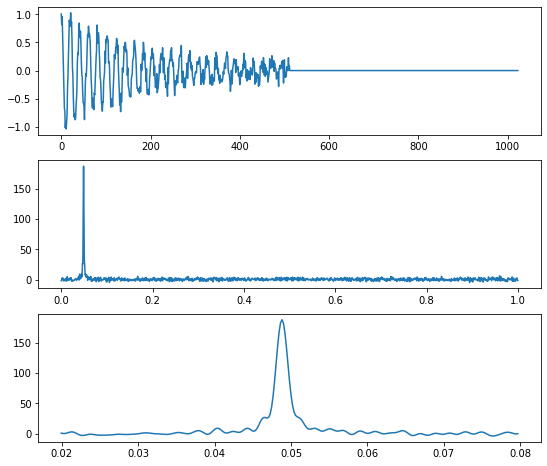

In [13]:
def plot_real_dat_detail_complex (xs,rys, ys,title='', xl='', yl='', detail=(0.0,1.0),save_name='Untitled.svg'):
    fig=plt.figure(figsize=(9, 8))

    ax0,ax1,ax2=fig.subplots(3)
    
    rxs = range(len(rys))
    ax0.plot(rxs,rys)

    ax1.plot(xs,np.real(ys))


   
    start = int(len(xs) * detail[0])
    end = int(len(xs) * detail[1])
    ax2.plot(xs[start:end],np.real(ys)[start:end])

    fig.savefig(save_name, bbox_inches='tight')
    
    plt.show()

    
def step(xs,ys,percentage=0.5):
    
    len_ys = len(ys)
    len_1s = int(len_ys *percentage)
    step = np.zeros(len_ys)
    for i in range(int(len(ys)*percentage)):
        step[i] = 1.0
        
    return xs, ys * step
        
    
@interact(percent=(0.0,1.0), noise_level=(0.0,3.0, 0.01))
def plot_fft_damped_sin_wave(percent=0.5, noise_level=0.1):
    frequency = 50
    
    relaxation=5
    
    xs,ysc = damped_sin_wave(frequency,relaxation)
    rysc = np.real(ysc)
    
    noise = np.random.normal(size=(len(rysc),)) * noise_level
    rysc += noise
    
    xs,ysc = step(xs,ysc,percent)
    rysc = np.real(ysc)
    xs,ysc =  zero_fill(xs,ysc,len(ysc)*4)
    yscft = fftpack.fft(ysc)

    plot_real_dat_detail_complex(xs,rysc, yscft,'cos wave', 'time', 'intensity',detail=(0.02,0.08))
    